# 1. RAFT training data generation using GPT-4o

In this notebook, we'll synthesize some training data that will eventually be used to fine-tune a GPT-4o mini model in order to adapt it to a set of document(s) and specific domain. **This step is critical as the quality of your training data will greatly influence the performance of your fine-tuned model.**

For RAFT, these are the different steps to prepare the training dataset:
- Collect Domain-Specific Documents: Gather documents relevant to the domain you want to specialize the LLM in (e.g., medical documents for PubMed, legal documents, API documentation for software).
- Chunk the file into Documents
- For each Document chunk, generate a set of Questions that can be answered from the Document
- For each Document-Question pair, create a list of documents using:
    - **Golden Document (D*)**: Document that contains the answer to the question.
    - **Distractor Documents (Dk)**: Documents that do not contain relevant information.
- Question-Answer-Document Triplets: From each **Document-Question** pair, generate a factual **Answer** based on the Golden Document.

Curating a good training dataset often involves manual work and review by SMEs. That said, we can use an LLM to help us generate an initial set of training examples that can be vetted and further refined by SMEs.


### 0. Pre-requisites

For this hands-on workshop, all you need is access to an Azure subscription and the ability to create Azure OpenAI resources and deployments. 

0. Install poppler for PDF processing

- on Linux run `sudo apt-get install -y poppler-utils`
- on Mac run `brew install poppler`
- on Windows run `conda install -c conda-forge poppler`

1. Create a code environment and install the necessary packages

```shell
conda create -n raft python=3.11

conda activate raft

pip install -r requirements.txt
```

2. Create a GPT-4o deployment
3. Create a GPT-4o mini deployment
4. Create an Azure OpenAI resource in North Central US or Sweden Central (regions where gpt-4o-mini fine tuning is supported)
5. Create a `.env` file based on the [sample.env](./sample.env) file in this repository to store your credentials and important environment variables. Paste your AOAI endpoints, keys and deployment names, name the file `.env`

**Import libraries**

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
import os
import random
from math import ceil
from tqdm import tqdm
from typing import Any, List, Dict, Tuple, Union, Optional, Literal

from langchain_experimental.text_splitter import SemanticChunker

from openai import AzureOpenAI

generator_client = AzureOpenAI(
    azure_endpoint=os.getenv("AOAI_GPT4o_ENDPOINT"),
    api_version=os.getenv("AOAI_GPT4o_API_VERSION"),
    api_key=os.getenv("AOAI_GPT4o_API_KEY"),
)

gpt4o_deployment = os.getenv("AOAI_GPT4o_DEPLOYMENT")


### 1. Loading and chunking domain-specific documents

For Retrieval Augmented Fine Tuning, we need to generate Question-Documents-Answer triplets. The first step is to create document chunks based on our domain-specific documents we want to specialize our model on.

For this workshop, we will use the publicly available [BMO Better Banking Guide](./data/better_banking_guide_en.pdf)

**Take a minute to browse through the PDF and become more familiar with its content**

The guide contains information about various banking accounts offered by BMO as well as how-to guides on e.g how to access Account statements etc.

The document is in PDF format and contains a number of tables and charts, we will use GPT-4o to convert the pages content to markdown. Credit to Liam Cavanagh for the inspiration.

**a. First we'll need to convert the document pages to images encoded in base64**

In [ ]:
import io
import base64

from pdf2image import convert_from_path


def pdf_to_base64_urls(pdf_path):
    """Converts each page of a PDF to a base64 encoded URL starting with 'data:image/jpeg'.

    Parameters:
      pdf_path: Path to the PDF file.

    Returns:
      A list of base64 encoded image URLs, one for each page.
    """

    images = convert_from_path(pdf_path)
    base64_urls = []

    for image in images:
        image_buffer = io.BytesIO()
        image.save(image_buffer, format="JPEG")
        image_buffer.seek(0)
        base64_encoded = base64.b64encode(image_buffer.read()).decode("utf-8")
        base64_url = f"data:image/jpeg;base64,{base64_encoded}"
        base64_urls.append(base64_url)

    return base64_urls


pdf_path = "./data/better_banking_guide_en.pdf"
image_data = pdf_to_base64_urls(pdf_path)

['',
 '',
 '']
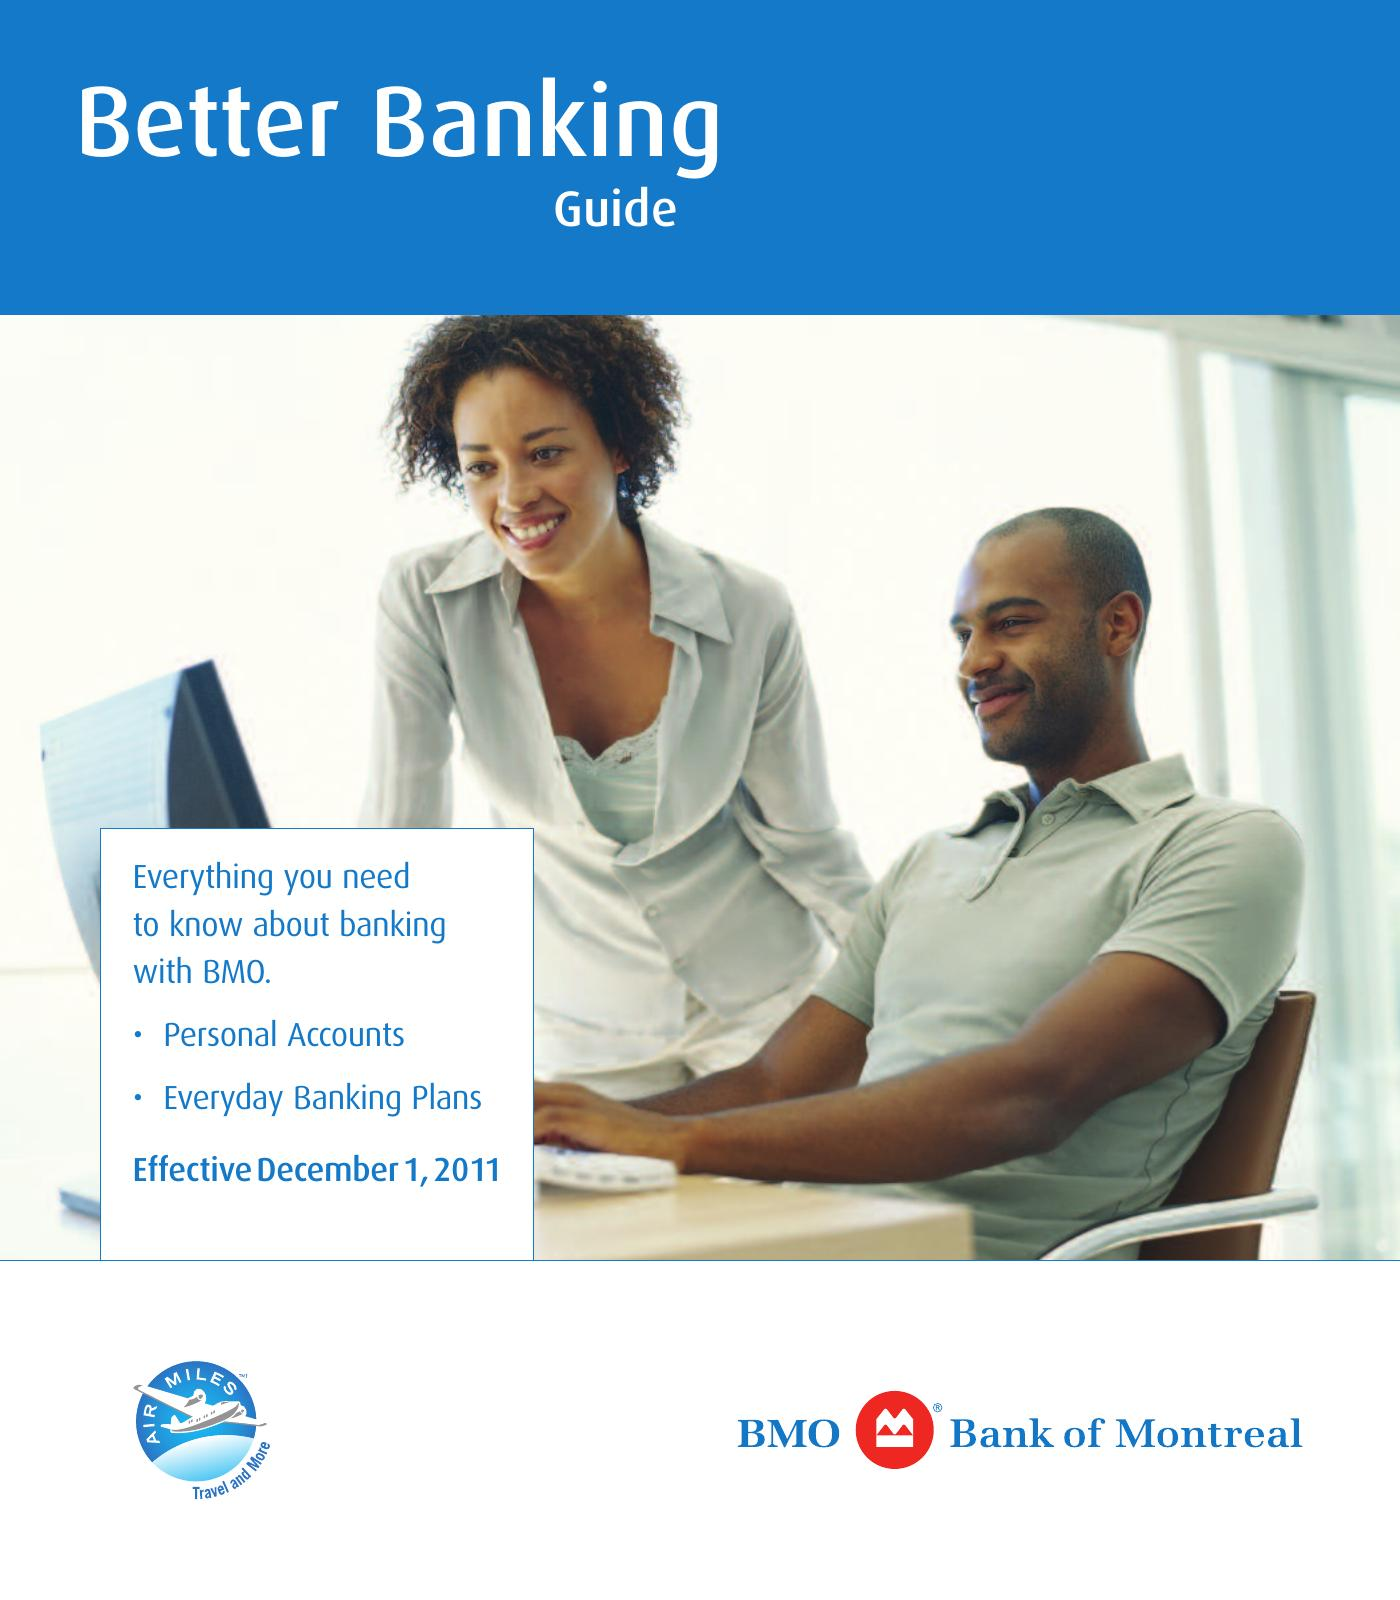
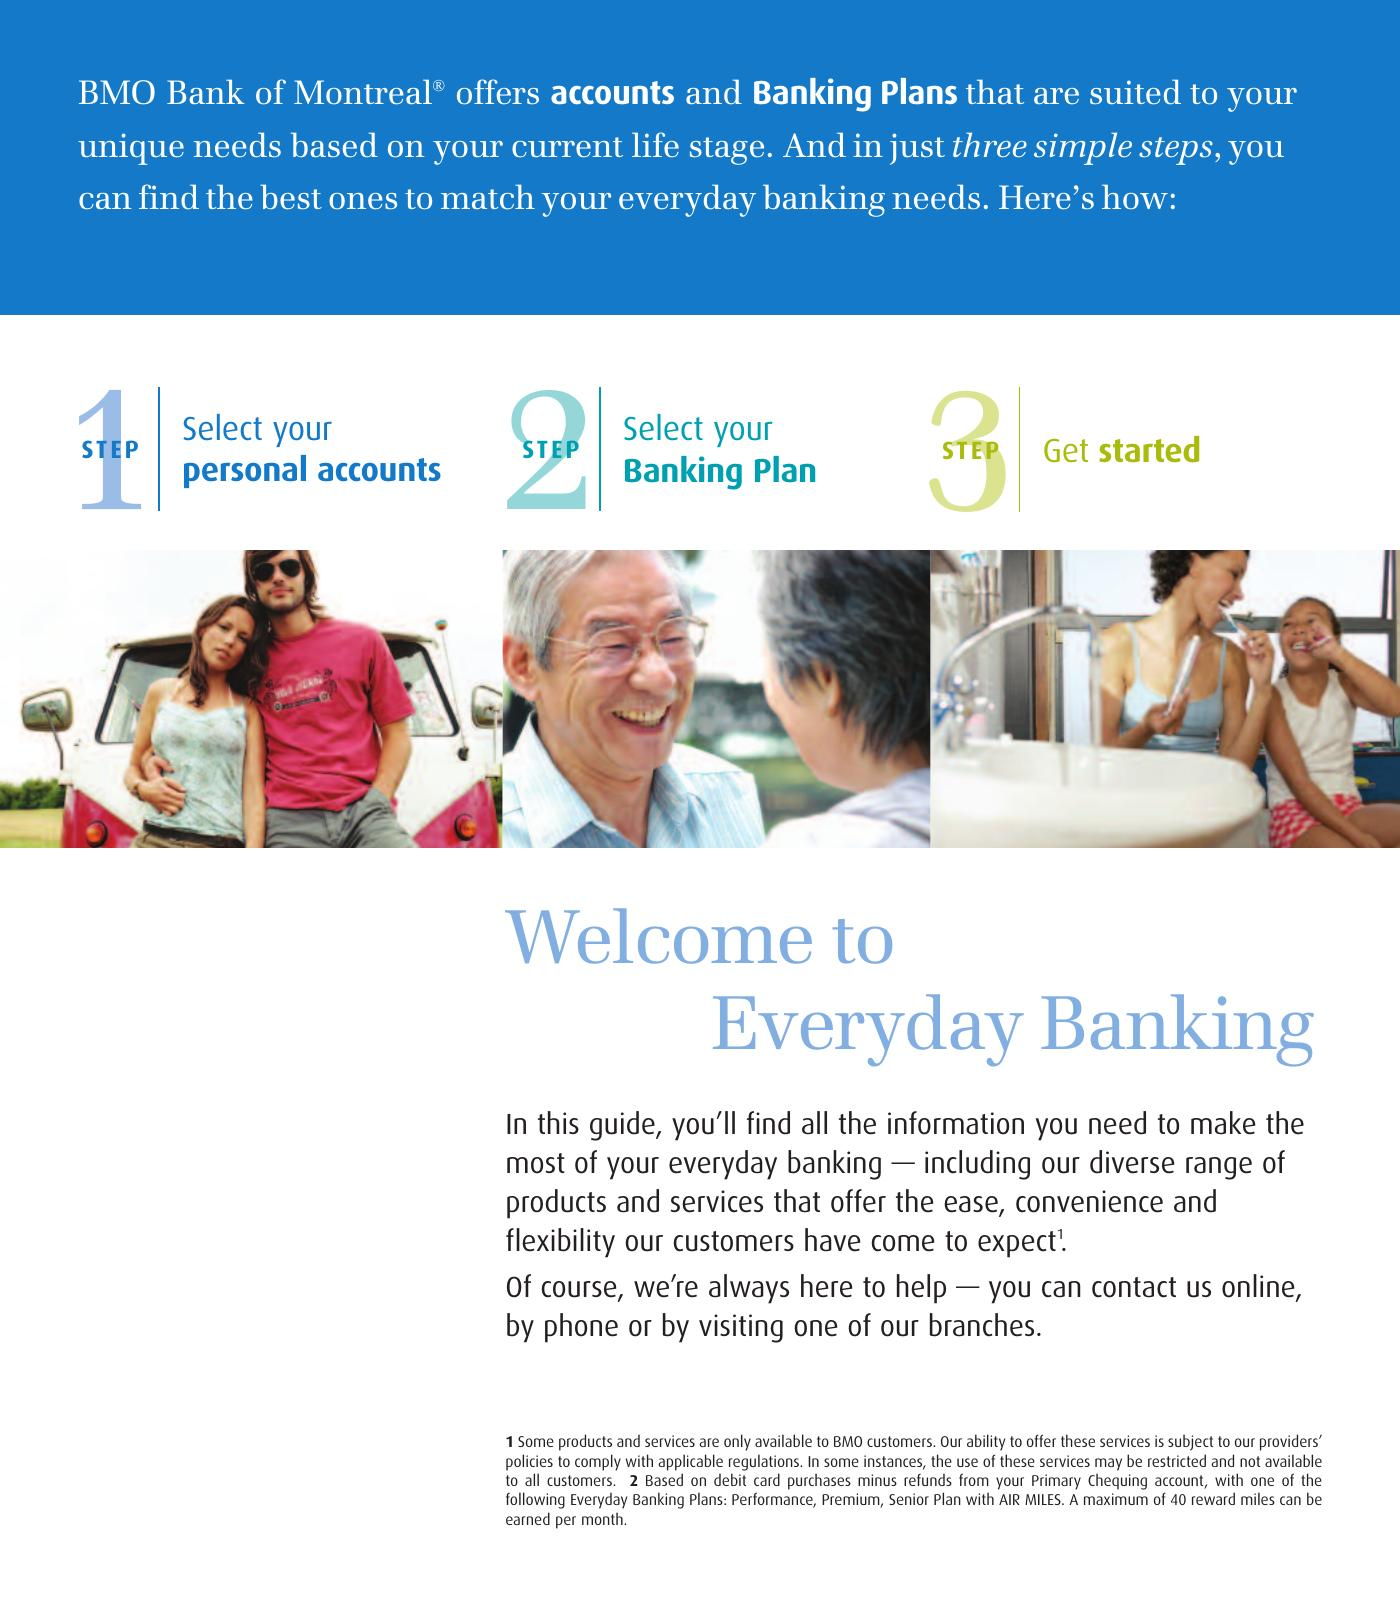
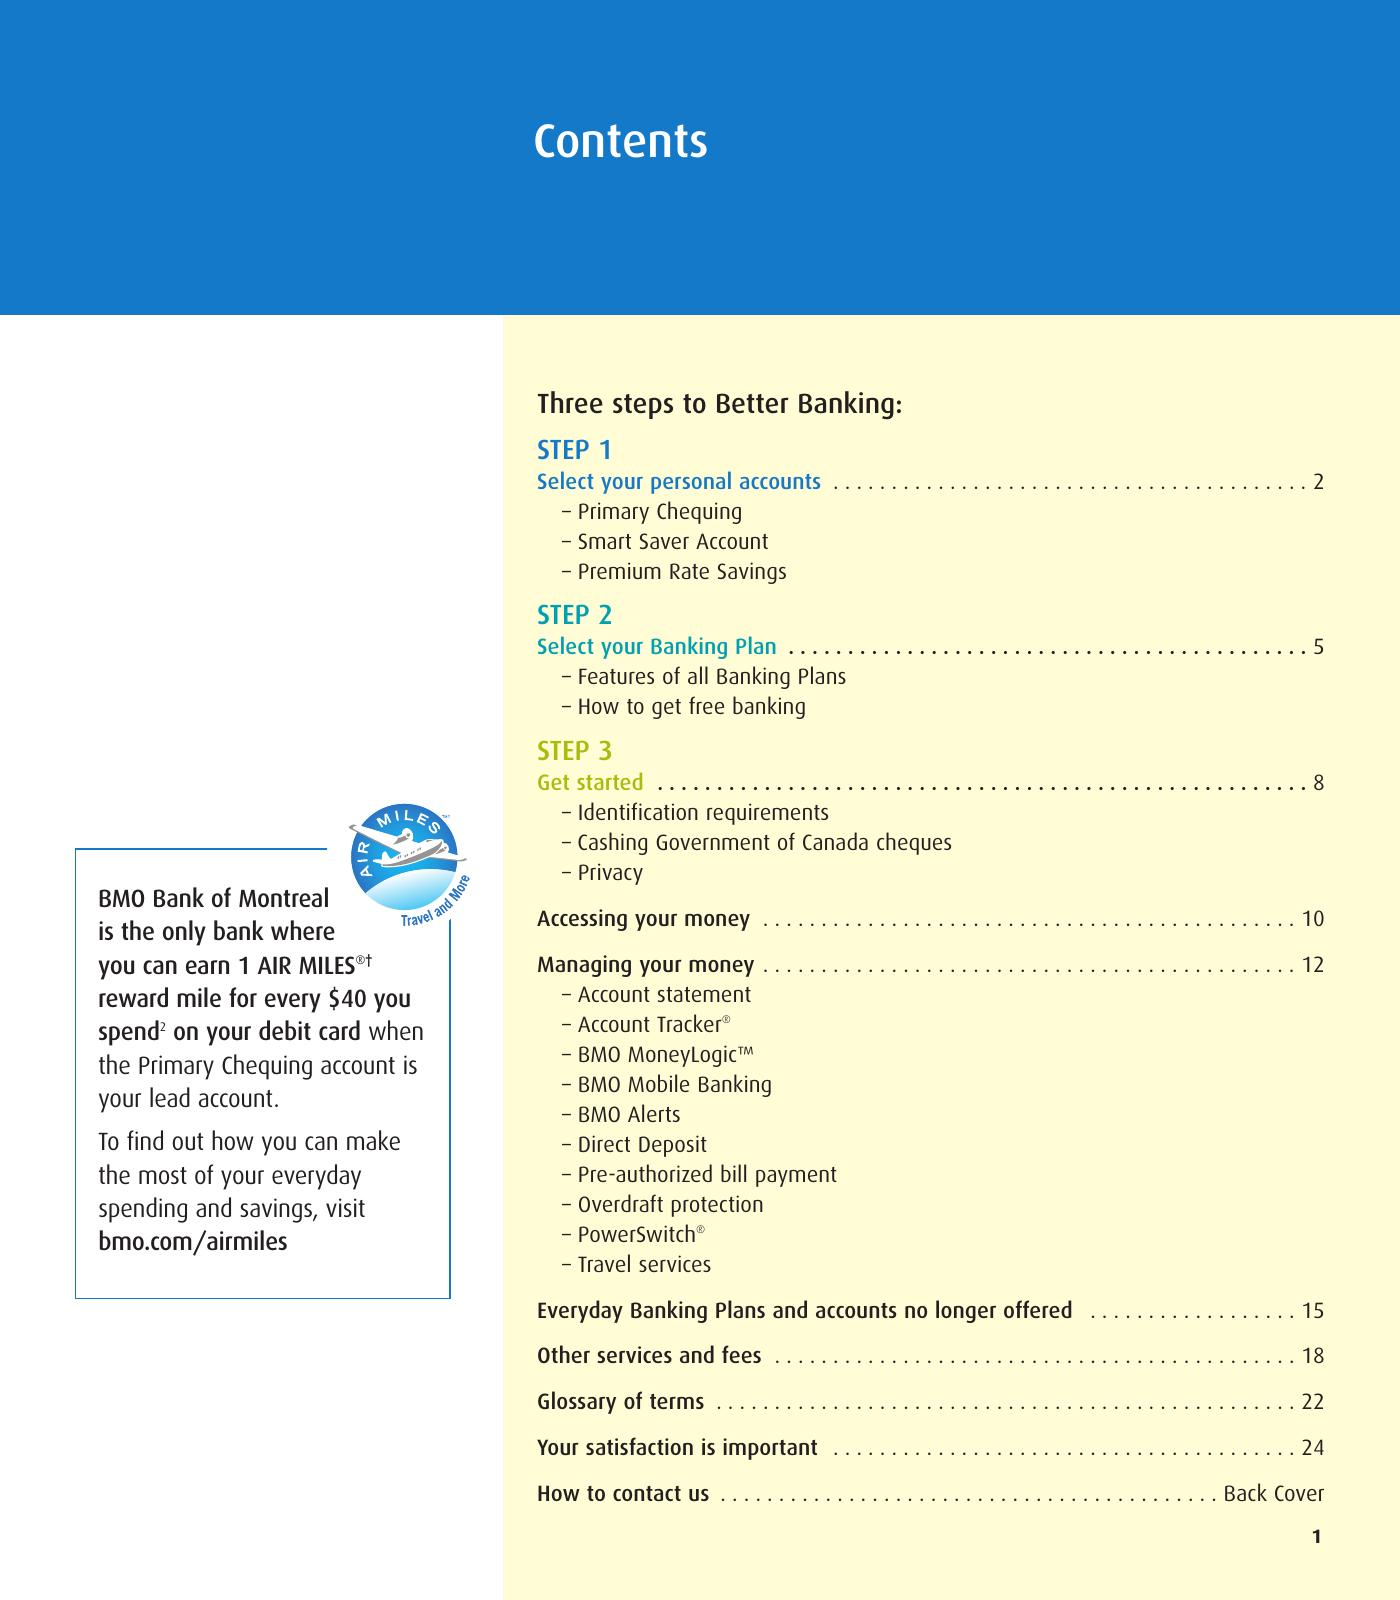

In [10]:
image_data[:3]

**b. Now we can call GPT-4o to convert our images to markdown**

In [11]:
def gpt_image_to_markdown(image_data, client):
    """
    Converts an image to markdown using GPT-4o.

    Parameters:
    image_data: A base64 encoded image.
    client: An AzureOpenAI client

    Returns:
    A list of base64 encoded image URLs, one for each page.
    """
    messages = [
        {
            "role": "system",
            "content": """You are an AI image assistant capable of extracting text from images
            Given an image, you must extract any visible text on the image and return it in Markdown.
            You must keep the original layout and formatting of the text as much as possible in Markdown format.
            Pay attention to the text size and use headers, subheaders, bold, italic, tables etc where necessary.""",
        },
        {
            "role": "user",
            "content": [{
                "type": "image_url", 
                "image_url": {"url": image_data}
            }],
        },
    ]

    try:
        response = client.chat.completions.create(
            model=gpt4o_deployment, 
            messages=messages
        )

        return response.choices[0].message.content
    except Exception as e:
        print(f"Error: {e}")
        return None

markdown_doc = ""

with tqdm(total=len(image_data), desc="Converting images to Markdown") as pbar:
    for image_line in image_data:
        result = gpt_image_to_markdown(image_line, generator_client)
        markdown_doc += "\n" + result
        pbar.update(1)


Converting images to Markdown: 100%|██████████| 26/26 [05:43<00:00, 13.19s/it]


In [12]:
markdown_doc

'\n```markdown\n# Better Banking  \n## Guide  \n\n---\n\n**Everything you need to know about banking with BMO.**  \n- Personal Accounts  \n- Everyday Banking Plans  \n\n**Effective December 1, 2011**  \n\n---\n\n![AIR MILES Logo] Travel and Miles  \n\n**BMO | Bank of Montreal**\n```\n```markdown\n**BMO Bank of Montreal** offers **accounts** and **Banking Plans** that are suited to your unique needs based on your current life stage. And in just **three simple steps**, you can find the best ones to match your everyday banking needs. Here’s how:\n\n---\n\n### 1  \n**STEP**  \nSelect your  \n**personal accounts**\n\n### 2  \n**STEP**  \nSelect your  \n**Banking Plan**\n\n### 3  \n**STEP**  \n**Get started**\n\n---\n\n## Welcome to Everyday Banking  \n\nIn this guide, you’ll find all the information you need to make the most of your everyday banking — including our diverse range of products and services that offer the ease, convenience and flexibility our customers have come to expect<sup>1

**c. Let's chunk the Markdown using Langchain**

We first use Langchain's `MarkdownHeaderTextSplitter` to split the document based on headers and then further split the chunks using `RecursiveCharacterTextSplitter` with a chunk size of 1024. Finally, we filter out any chunks that are too short to contain any valuable information.

In [13]:
from langchain_text_splitters import (
    MarkdownHeaderTextSplitter,
    RecursiveCharacterTextSplitter,
)
import re


def remove_special_characters(string):
    """
    Remove special characters from a string.

    Parameters:
    string (str): The input string from which special characters need to be removed.

    Returns:
    str: A new string with special characters removed.
    """
    return re.sub(r"[^a-zA-Z0-9\s]", "", string)


headers_to_split_on = [("#", "Header 1"), ("##", "Header 2")]

markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=False
)

markdown_doc_splits = markdown_splitter.split_text(markdown_doc)
print(f"Number of chunks after markdown split: {len(markdown_doc_splits)}")

chunk_size = 1024
chunk_overlap = 50
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)


chunked_document = text_splitter.split_documents(markdown_doc_splits)

print(f"Number of chunks after markdown + recursive split: {len(chunked_document)}")

chunks = [
    chunk.page_content
    for chunk in chunked_document
    if len(remove_special_characters(chunk.page_content)) > 100
]

print(f"Number of chunks after filtering out empty: {len(chunks)}")


Number of chunks after markdown split: 1
Number of chunks after markdown + recursive split: 114
Number of chunks after filtering out empty: 110


### 2. Generate training data from the chunked documents

We define 2 main functions to generate our Question-Document-Answer triplets from our chunked document

1. `generate_instructions_gen()`: This function generates a list of questions based on an input document chunk
2. `generate_label()`: This function generates an Answer based on a Question-Document chunk pair

**a. First, lets look at the `generate_instructions_gen()` function on a sample**

In [ ]:
def strip_text(text: str) -> str:
    """
    Helper function for helping format strings returned by GPT-4o.

    Parameters:
    s (str): The input string to be formatted.

    Returns:
    str: A formatted string
    """
    left, right = 0, len(text) - 1
    found_beginning = False
    for cursor in range(len(text)):
        if text[cursor].isalpha():
            if not found_beginning:
                left = cursor
                found_beginning = True
            else:
                right = cursor
    right += 2
    return text[left : min(right, len(text))]

def generate_instructions_gen(
    client: AzureOpenAI, 
    chunk: Any, 
    x: int = 5, 
    model: str = None
) -> list[str]:
    """
    Generates a list of questions or use cases based on a provided chunk of context using an Azure OpenAI model.

    Parameters:
    client (AzureOpenAI): An instance of the Azure OpenAI client used to communicate with the OpenAI API.
    chunk (Any): The context or chunk of text based on which the questions are to be generated.
    x (int, optional): The number of questions to generate. Default is 5.
    model (str, optional): The specific model to use for generating the questions. Default is None, which uses the default model configured in the client.

    Returns:
    list[str]: A list of generated questions.
    """
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a synthetic question-answer pair generator. Given a chunk of context about some topic(s), generate exactly %s example questions a user could ask and would be answered using information from the chunk. For example, if the given context was a Wikipedia paragraph about the United States, an example question could be 'How many states are in the United States?'"
                % (x),
            },
            {
                "role": "system",
                "content": "The questions should be able to be answered in a few words or less. Include only the questions in your response.",
            },
            {
                "role": "user", 
                "content": str(chunk)
            },
        ],
    )

    queries = response.choices[0].message.content.split("\n")
    queries = [strip_text(q) for q in queries]
    queries = [q for q in queries if any(c.isalpha() for c in q)]
    return queries[: int(x)]

Let's visualize an example picked randomly from our Document chunks

In [ ]:
sample_index = random.randint(0, len(chunks) - 1)

chunk = chunks[sample_index]

queries = generate_instructions_gen(
    generator_client, chunk, x=5, model=gpt4o_deployment
)

In [16]:
print(chunk)

| - International: Monthly number of debit transactions using non-BMO ABMs on the **Cirrus®** network           | 5                     | 5                | 2             | 2                   | 2                | 2                             |
| - International: Debit card transactions at merchants using the **Maestro®** network                          | ✓                     | ✓                | ✓             | ✓                   | ✓                | ✓                             |
|   (number of transactions subject to monthly transaction limit for the selected plan)*                        |                       |                  |               |                     |                  |                               |
| - Preferred exchange rate when buying or selling U.S. cash                                                    | ✓                     | ✓                | ✓             | ✓                   | ✓                | ✓                             |


In [17]:
queries


['What network is used for international debit transactions at non-BMO ATMs?',
 'Are debit card transactions at merchants on the Maestro® network supported internationally?',
 'Does the selected plan have a monthly transaction limit for international transactions?',
 'Is a preferred exchange rate offered for U.S. cash transactions?',
 'Does Cirrus® support a fixed number of international debit transactions per month?']

**b. Generating questions, answers and adding distractor documents** 

In [18]:
from datasets import Dataset, load_dataset
import random
from typing import Any

def encode_question_gen(question: str, chunk: Any) -> list[str]:
    """
    Encode multiple prompt instructions into a single string for the general case (`pdf`, `json`, or `txt`).

    Parameters:
    question (str): The question to be answered.
    chunk (Any): The context or chunk of text that provides the information needed to answer the question.

    Returns:
    list[str]: A list of messages formatted for the language model API, including system and user roles.
    """

    prompts = []

    prompt = """
        Question: {question}\n Context: {context}\n
        Answer this question using the information given in the context above and no prior knowledge. Here are things to pay attention to: 
        - First provide step-by-step reasoning on how to answer the question. 
        - In the reasoning, if you need to copy paste some sentences from the context, include them in ##begin_quote## and ##end_quote##. This would mean that things outside of ##begin_quote## and ##end_quote## are not directly copy pasted from the context. 
        - End your response with the final answer in the form <ANSWER>: $answer, the answer should be given in a joyful and friendly tone.
        - If the answer cannot be found in the context, say "I'm sorry, I cannot answer this question as I'm missing the required information"
        You MUST begin your final answer with the tag "<ANSWER>:".
    """.format(question=question, context=str(chunk))

    prompts.append(
        {
            "role": "system",
            "content": "You are a helpful question answerer who can provide an answer given a question and relevant context.",
        }
    )

    prompts.append({"role": "user", "content": prompt})

    return prompts


def generate_label(
    client: AzureOpenAI, question: str, context: Any, model: str = None
) -> str | None:
    """
    Generates the label / answer to `question` using `context` and GPT-4o.

    Parameters:
    client (AzureOpenAI): An instance of the Azure OpenAI client used to communicate with the OpenAI API.
    question (str): The question to be answered.
    context (Any): The context or chunk of text that provides the information needed to answer the question.
    model (str, optional): The specific model to use for generating the answer. Default is None, which uses the default model configured in the client.

    Returns:
    str | None: The generated answer from the language model, or None if no answer was generated.
    """
    question = encode_question_gen(question, context)

    response = client.chat.completions.create(
        model=model, messages=question, n=1, temperature=0
    )

    response = response.choices[0].message.content

    return response


def add_chunk_to_dataset(
    client: AzureOpenAI,
    chunks: list[str],
    chunk: str,
    x: int = 5,
    num_distract: int = 3,
    p: float = 0.8,
    model: str = None,
) -> None:
    """
    Given a chunk, create {Q, A, D} triplets and add them to the dataset.

     Parameters:
    client (AzureOpenAI): An instance of the Azure OpenAI client used to communicate with the OpenAI API.
    chunks (list[str]): A list of chunks of text from which distractor documents can be sampled.
    chunk (str): The chunk of text to use as the primary context for generating questions and answers.
    x (int, optional): The number of questions to generate for the given chunk. Default is 5.
    num_distract (int, optional): The number of distractor documents to include with each question. Default is 3.
    p (float, optional): The probability of including the oracle (original) document as part of the context. Default is 0.8.
    model (str, optional): The specific model to use for generating questions and answers. Default is None, which uses the default model configured in the client.
    """
    global ds
    global errors
    
    i = chunks.index(chunk)

    try:
        qs = generate_instructions_gen(client, chunk, x, model)
    except Exception as e:
        errors.append(e)
        return None
    
    for q in qs:
        datapt = {
            "id": None,
            "type": None,
            "question": None,
            "context": None,
            "oracle_context": None,
            "cot_answer": None,
        }

        datapt["id"] = f"seed_task_{i}"
        datapt["type"] = "general"
        datapt["question"] = q

        # add num_distract distractor docs
        docs = [chunk]
        indices = list(range(0, len(chunks)))
        indices.remove(i)
        for j in random.sample(indices, num_distract):
            docs.append(chunks[j])

        # decides whether to add oracle document
        oracle = random.uniform(0, 1) < p
        if not oracle:
            docs[0] = chunks[random.sample(indices, 1)[0]]
        random.shuffle(docs)

        d = {"title": [], "sentences": []}

        d["title"].append(["placeholder_title"] * (num_distract + 1))
        d["sentences"].append(docs)
        datapt["context"] = d
        datapt["oracle_context"] = chunk

        # add answer to q
        try:
            datapt["cot_answer"] = generate_label(client, q, chunk, model=model)
        except Exception as e:
            errors.append(e)
            continue

        # construct model instruction
        context = ""
        for doc in docs:
            context += "<DOCUMENT>" + str(doc) + "</DOCUMENT>\n"
        context += q
        datapt["instruction"] = context

        # add to dataset
        if not ds:
            # init ds
            datapt["id"] = [datapt["id"]]
            datapt["type"] = [datapt["type"]]
            datapt["question"] = [datapt["question"]]
            datapt["context"] = [datapt["context"]]
            datapt["oracle_context"] = [datapt["oracle_context"]]
            datapt["cot_answer"] = [datapt["cot_answer"]]
            datapt["instruction"] = [datapt["instruction"]]
            ds = Dataset.from_dict(datapt)
        else:
            ds = ds.add_item(datapt)

**Let's execute this function a in multi-threaded way to speed up the process**

In [19]:
from tqdm import tqdm
import concurrent.futures

errors = []
ds = Dataset.from_dict({})


def process_chunk(chunk):
    add_chunk_to_dataset(generator_client, chunks, chunk, 5, 3, model=gpt4o_deployment)


# Create a ThreadPoolExecutor with the desired number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit the tasks to the executor and store the Future objects
    futures = [executor.submit(process_chunk, chunk) for chunk in chunks]

    # Use tqdm to create a progress bar
    with tqdm(total=len(chunks), desc="Processing chunks") as pbar:
        # Iterate over the completed futures as they become available
        for future in concurrent.futures.as_completed(futures):
            # Get the result of the completed future
            result = future.result()
            # Update the progress bar
            pbar.update(1)

# Print any errors that occurred during processing
print(f"Number of processing errors: {errors}/{len(chunks)}")

Processing chunks: 100%|██████████| 110/110 [12:15<00:00,  6.68s/it] 

Number of processing errors: [RateLimitError("Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-08-01-preview have exceeded token rate limit of your current AIServices S0 pricing tier. Please retry after 40 seconds. Please contact Azure support service if you would like to further increase the default rate limit.'}}"), RateLimitError("Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-08-01-preview have exceeded token rate limit of your current AIServices S0 pricing tier. Please retry after 40 seconds. Please contact Azure support service if you would like to further increase the default rate limit.'}}"), RateLimitError("Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-08-01-preview have exceeded token rate limit of y

In [20]:
training_df = ds.to_pandas()

print(
    f"{training_df.shape[0]} rows and {training_df.shape[1]} columns in the training dataset"
)

92 rows and 7 columns in the training dataset


In [21]:
# Previewing the generated data

training_df.head(2)

,id,type,question,context,oracle_context,cot_answer,instruction
0,seed_task_16,general,Can the account be accessed in U.S. dollars?,{'sentences': [['We will cash your Government ...,| - Account is available in Canadian or U.S. d...,Step-by-step reasoning:\n\n1. The question ask...,<DOCUMENT>We will cash your Government of Cana...
1,seed_task_13,general,What is the minimum daily balance required to ...,{'sentences': [['--- ¹ Service from midnight ...,| - View processed cheques online. ...,Step-by-step reasoning:\n\n1. The question ask...,<DOCUMENT>---\n\n¹ Service from midnight to 7:...


**c. Formatting the data in chat format for fine tuning with Azure OpenAI**

The conversational chat format is required to fine-tune gpt-4o-mini

In [22]:
training_df["messages"] = training_df.apply(
    lambda x: [
        {"role": "user", "content": x["instruction"]},
        {"role": "assistant", "content": x["cot_answer"]},
    ],
    axis=1,
)

In [23]:
training_df.messages.values[12]

[{'role': 'user',
  'content': '<DOCUMENT>| **Added Protection**                                                                                           |                       |                  |               |                     |                  |                               |\n| - Overdraft Transfer Service (between personal accounts in the Banking Plan to cover overdraft at no extra charge) | ✓                     | ✓                | ✓             | ✓                   | ✓                | ✓                             |\n| - Overdraft protection up to $500 U.S. on U.S. dollar chequing accounts in good standing*                      | ✓                     | ✓                | ✓             | ✓                   | ✓                | ✓                             |\n| - Personal Credit Reserve® (up to $2,500) with no monthly fee or per item fee*                                 | ✓                     | ✓                | ✓             | ✓                   | ✓             

In [24]:
training_df.dropna(subset=["cot_answer"], inplace=True)

### 2. Spitting our data into training and test sets

Splitting your data into training, validation and testing sets when fine-tuning a large language model (LLM) is crucial for ensuring the model's performance and generalization capabilities. The training set is used to teach the model, allowing it to learn patterns from the data. The validation set is used to track performance metrics during the training to avoid underfitting / overfitting. However, to objectively evaluate how well the model has learned and to ensure it can generalize to unseen data, a separate testing set is necessary. 

We will use this test set in order to measure the improvement of performance we get from using RAFT over RAG with gpt-4o-mini

In [25]:
import numpy as np

train_df, validate_df, test_df = np.split(
    training_df.sample(frac=1, random_state=42),
    [int(0.8 * len(training_df)), int(0.9 * len(training_df))],
)

print(
    f"Train: {train_df.shape[0]}, Validate: {validate_df.shape[0]}, Test: {test_df.shape[0]}"
)

Train: 73, Validate: 9, Test: 10


/home/lambdakris/source/krs-labs/azure-openai-raft/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [26]:
if not os.path.exists("./data/training_data"):
    os.makedirs("./data/training_data")

train_df[["messages"]].to_json(
    "./data/training_data/banking_train.jsonl", orient="records", lines=True
)
test_df.to_json("./data/training_data/banking_test.jsonl", orient="records", lines=True)
validate_df[["messages"]].to_json(
    "./data/training_data/banking_validation.jsonl", orient="records", lines=True
)

#### Congrats! We now have a labelled training dataset and a test dataset to evaluate our model's performance. Now go to the [finetuning notebook](./raft_finetuning.ipynb)